In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter

In [2]:
import glob
vec_path = glob.glob("../data/vecs/*.pkl")[0]
vec_path

'../data/vecs\\abo16-finetune-flc-psm.03.v0.vec.pkl'

In [3]:
with open(vec_path, "rb") as fin:
    evals = pickle.load(fin)

In [4]:
ans = evals["ans"]
ans_lst = sorted(set(ans))
preds = evals["preds"]
mask = np.array([x == y for x, y in zip(ans, preds)])

hlast = evals["last"][mask, :]
h0 = evals["h0"][mask, :]
h6 = evals["h6"][mask, :]
ans = np.array(ans)[mask]

In [5]:

writer = SummaryWriter("../data/emb")
writer.add_embedding(hlast, metadata=ans, tag='hlast')
writer.add_embedding(h0, metadata=ans, tag='h0')
writer.add_embedding(h6, metadata=ans, tag='h6')
writer.close()

In [6]:
len(hlast)

1341

## PCA

cumulative variance 0.5396376


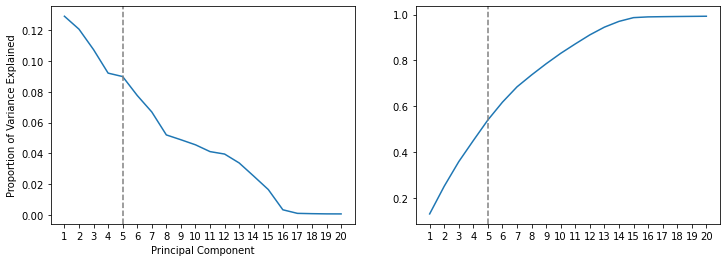

In [7]:
from sklearn.decomposition import PCA
pca = PCA(20)
K = 5
pca.fit(hlast)
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(20)+1, pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
_ = plt.gca().set_xticks(np.arange(20)+1)
plt.axvline(K, linestyle='--', color='gray')
plt.subplot(1, 2, 2)
cumvar = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(20)+1, cumvar)
print("cumulative variance", cumvar[K-1])
plt.axvline(K, linestyle='--', color='gray')
_ = plt.gca().set_xticks(np.arange(20)+1)

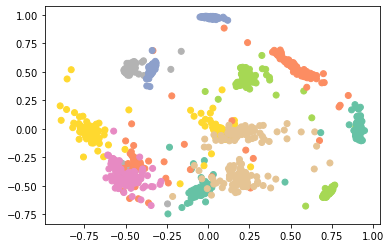

In [11]:
pca2 = PCA(K)
hlast_proj = pca2.fit_transform(hlast)
hlast_norm = hlast_proj / np.linalg.norm(hlast_proj, axis=1)[:, np.newaxis]
ans_idx = [ans_lst.index(x) for x in ans]
plt.scatter(hlast_norm[:, 0], hlast_norm[:, 1], c=ans_idx, cmap="Set2")

In [12]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
medoids = []
for ans_x in ans_lst:
    mat = hlast_norm[ans==ans_x]
    D = squareform(pdist(mat, metric='cosine'))
    med_idx = np.argmin(D.sum(axis=0))
    medoids.append(mat[med_idx])    

In [13]:
len(medoids)

16

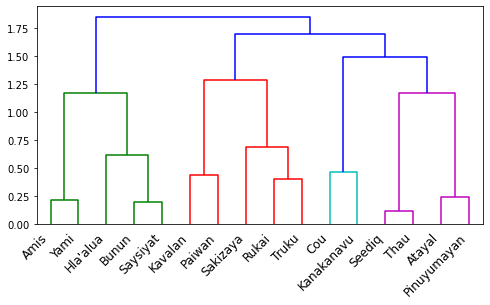

In [14]:
plt.figure(figsize=(8,4))
Dm = pdist(medoids, metric='cosine')
Zm = linkage(Dm, method='complete')
dendrogram(Zm, labels=ans_lst, leaf_rotation=45)
xlabels = plt.gca().get_xticklabels()
_ = plt.gca().set_xticklabels(xlabels, ha='right')

## Compute LDA

In [15]:
feat_phones = pd.read_csv("../data/langfeats/feat_phones.csv", index_col=0)

In [17]:
from scipy.stats import entropy
feat_mat = np.array(feat_phones)
p = (feat_mat==1).sum(axis=0)/12
log2p = lambda x: [np.log2(p) if p>0 else 0 for p in x]
feat_entropies = -p*log2p(p)-(1-p)*log2p(1-p)
feat_entropies_orders = feat_entropies.argsort()[::-1]

In [18]:
p=np.array([0.75]);-p*log2p(p)-(1-p)*log2p(1-p)

array([0.81127812])

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
feat_ldas = []
for feat_idx in feat_entropies_orders:    
    feat_ent = feat_entropies[feat_idx]
    if feat_ent < 0.8113: continue
    
    feat_x = feat_phones.iloc[:, feat_idx]
    feat_name = feat_x.name
    ymap = feat_x.to_dict()
    
    lda = LinearDiscriminantAnalysis()            
    y = [ymap.get(x,0) for x in ans]
    lda.fit(hlast_proj, y)
    score = lda.score(hlast_norm, y)
    coefs = lda.coef_[0]
    intc = lda.intercept_[0]
    feat_ldas.append(dict(
        feat_name=feat_name, 
        feat_ent=feat_ent,
        score=score,
        coefs=coefs, intc=intc
    ))

In [20]:
len(feat_ldas)

31

15 left, with score cutpoint set to  0.6964951528709918


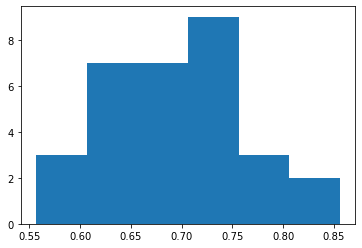

In [21]:
plt.hist([x["score"] for x in feat_ldas], 6)
score_q2 = np.quantile([x["score"] for x in feat_ldas], 0.5)
feat_q2 = len([x["score"] for x in feat_ldas if x["score"] > score_q2])
print(feat_q2, "left, with score cutpoint set to ", score_q2)

In [22]:
lda_subs = [x for x in feat_ldas if x["score"] > score_q2]
coefs = np.vstack([x["coefs"] for x in lda_subs])

In [23]:
np.set_printoptions(precision=2)
for ki in range(K):    
    print("----", ki, "-----")
    order_ki = np.argsort(coefs[:, ki])[::-1]
    pos_inst = lda_subs[order_ki[0]]
    print(f"Positive: {pos_inst['feat_name']}, ({pos_inst['coefs'][ki]:.2f})")
    print(f"          lda score: {pos_inst['score']:.2f}")
    print(f"          {pos_inst['coefs']}")
    neg_inst = lda_subs[order_ki[-1]]
    print(f"Negative: {neg_inst['feat_name']}, ({neg_inst['coefs'][ki]:.2f})")
    print(f"          lda score: {neg_inst['score']:.2f}")
    print(f"          {neg_inst['coefs']}")
np.set_printoptions(precision=8)

---- 0 -----
Positive: GlottalVoicelessfricative, (0.47)
          lda score: 0.82
          [ 0.47 -0.34 -0.03 -0.04 -0.37]
Negative: Alveolarvoicedfricative, (-0.76)
          lda score: 0.73
          [-0.76 -0.54 -0.18 -0.38 -0.13]
---- 1 -----
Positive: Midfrontvowel, (0.16)
          lda score: 0.75
          [ 0.42  0.16  0.05  0.02 -0.4 ]
Negative: Bilabialvelarvoicedapproximant, (-0.63)
          lda score: 0.74
          [ 0.07 -0.63 -0.04 -0.15  0.02]
---- 2 -----
Positive: PalatalalveolarvoicelesssibilantFric, (0.40)
          lda score: 0.75
          [ 0.25  0.07  0.4   0.2  -0.76]
Negative: Bilabialvoicedfricative, (-0.18)
          lda score: 0.73
          [-0.19 -0.31 -0.18 -0.25  0.  ]
---- 3 -----
Positive: midbackroundedvowel, (0.43)
          lda score: 0.86
          [ 0.15 -0.38  0.23  0.43 -0.8 ]
Negative: voicedalveolarsibilantfricative, (-0.55)
          lda score: 0.73
          [-0.21 -0.1   0.03 -0.55 -0.26]
---- 4 -----
Positive: Bilabialvelarvoicedapprox

In [24]:
np.set_printoptions(precision=2)
for lang, med in zip(ans_lst, medoids):
    print("{:12s} {}".format(lang, med))
np.set_printoptions(precision=8)

Amis         [-0.03 -0.56 -0.13  0.81 -0.09]
Atayal       [ 0.92  0.02 -0.37 -0.08  0.12]
Bunun        [-0.36 -0.28 -0.4  -0.43 -0.66]
Cou          [ 0.53  0.54  0.   -0.06 -0.65]
Hla'alua     [-0.35  0.52 -0.76  0.   -0.15]
Kanakanavu   [ 0.01  0.98  0.03 -0.19  0.02]
Kavalan      [-0.49 -0.44  0.51 -0.55 -0.07]
Paiwan       [-0.55 -0.33 -0.37 -0.64  0.2 ]
Pinuyumayan  [ 0.73 -0.56 -0.15 -0.3   0.2 ]
Rukai        [ 0.23  0.43  0.64 -0.35  0.47]
Sakizaya     [ 0.07 -0.03  0.    0.38  0.92]
Saysiyat     [-0.72 -0.02 -0.45 -0.02 -0.53]
Seediq       [ 0.23 -0.05  0.83  0.32 -0.39]
Thau         [ 0.17 -0.44  0.59  0.36 -0.54]
Truku        [-0.47  0.54  0.54  0.19  0.4 ]
Yami         [-0.51 -0.32 -0.43  0.64 -0.2 ]
